In [2]:
import ijson
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# set options for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [4]:
def extract_json_data_into_dataframe(json_file_path: str, no_of_entries: int) -> pd.DataFrame:
    """
    extracts the json data from the json file and returns a pandas dataframe
    :param json_file_path: path to the json file
    :param no_of_entries: number of entries to be extracted from the json file
    :return: pandas dataframe containing the extracted data
    """
    df = pd.DataFrame()

    f = open(json_file_path, 'r')
    for i, json_event in enumerate(ijson.items(f, 'item')):
        single_df = pd.json_normalize(json_event)
        df = pd.concat([df, single_df], ignore_index=True)
        if i == no_of_entries:
            break
    f.close()

    return df

df = extract_json_data_into_dataframe('stuttgart_events.json', 100)
print(df)

                                                                                                id  \
0                 prinz.de/stuttgart/events/515144-gedenktag-fuer-die-verstorbenen-drogenabhaeng-1   
1                                         prinz.de/stuttgart/events/172968-get-shorties-lesebuehne   
2                         prinz.de/stuttgart/events/200783-stuttgarter-saloniker-neujahrskonzert-1   
3                                                      prinz.de/stuttgart/events/424139-beefcake-2   
4                                        prinz.de/stuttgart/events/203179-3durch3reihe-sprachkunst   
5                                             prinz.de/stuttgart/events/185016-grand-hotel-abgrund   
6                                                      prinz.de/stuttgart/events/483305-beefcake-9   
7                                                    prinz.de/stuttgart/events/477202-nus-quintett   
8                                                 prinz.de/stuttgart/events/242882

# Data Preprocessing

## Remove all events that take place at locations not in Stuttgart

In [5]:
def remove_events_not_in_stuttgart(df: pd.DataFrame) -> pd.DataFrame:
    """
    Remove all events not in Stuttgart by looking at the evntData.location.location.city column
    :param df: dataframe containing the events
    :return: dataframe containing only events in Stuttgart (might be the same as inpt df)
    """
    df = df[df['eventData.location.location.address.city'] == 'Stuttgart']
    return df

df = remove_events_not_in_stuttgart(df)

In [6]:
print(df.shape)

(101, 60)


### Check for NA values

In [7]:
# check for NA values
print(df.isna().sum())

id                                                           0
hostname                                                     0
eventData.name                                               0
eventData.description                                        0
eventData.sourceId                                           0
eventData.url                                                0
eventData.startDate                                          0
eventData.endDate                                          101
eventData.doorTime                                         101
eventData.cancelled                                          0
eventData.location.sourceId                                  0
eventData.location.url                                       0
eventData.location.name                                      0
eventData.location.description                             101
eventData.location.location.name                             0
eventData.location.location.address.country.shortName  

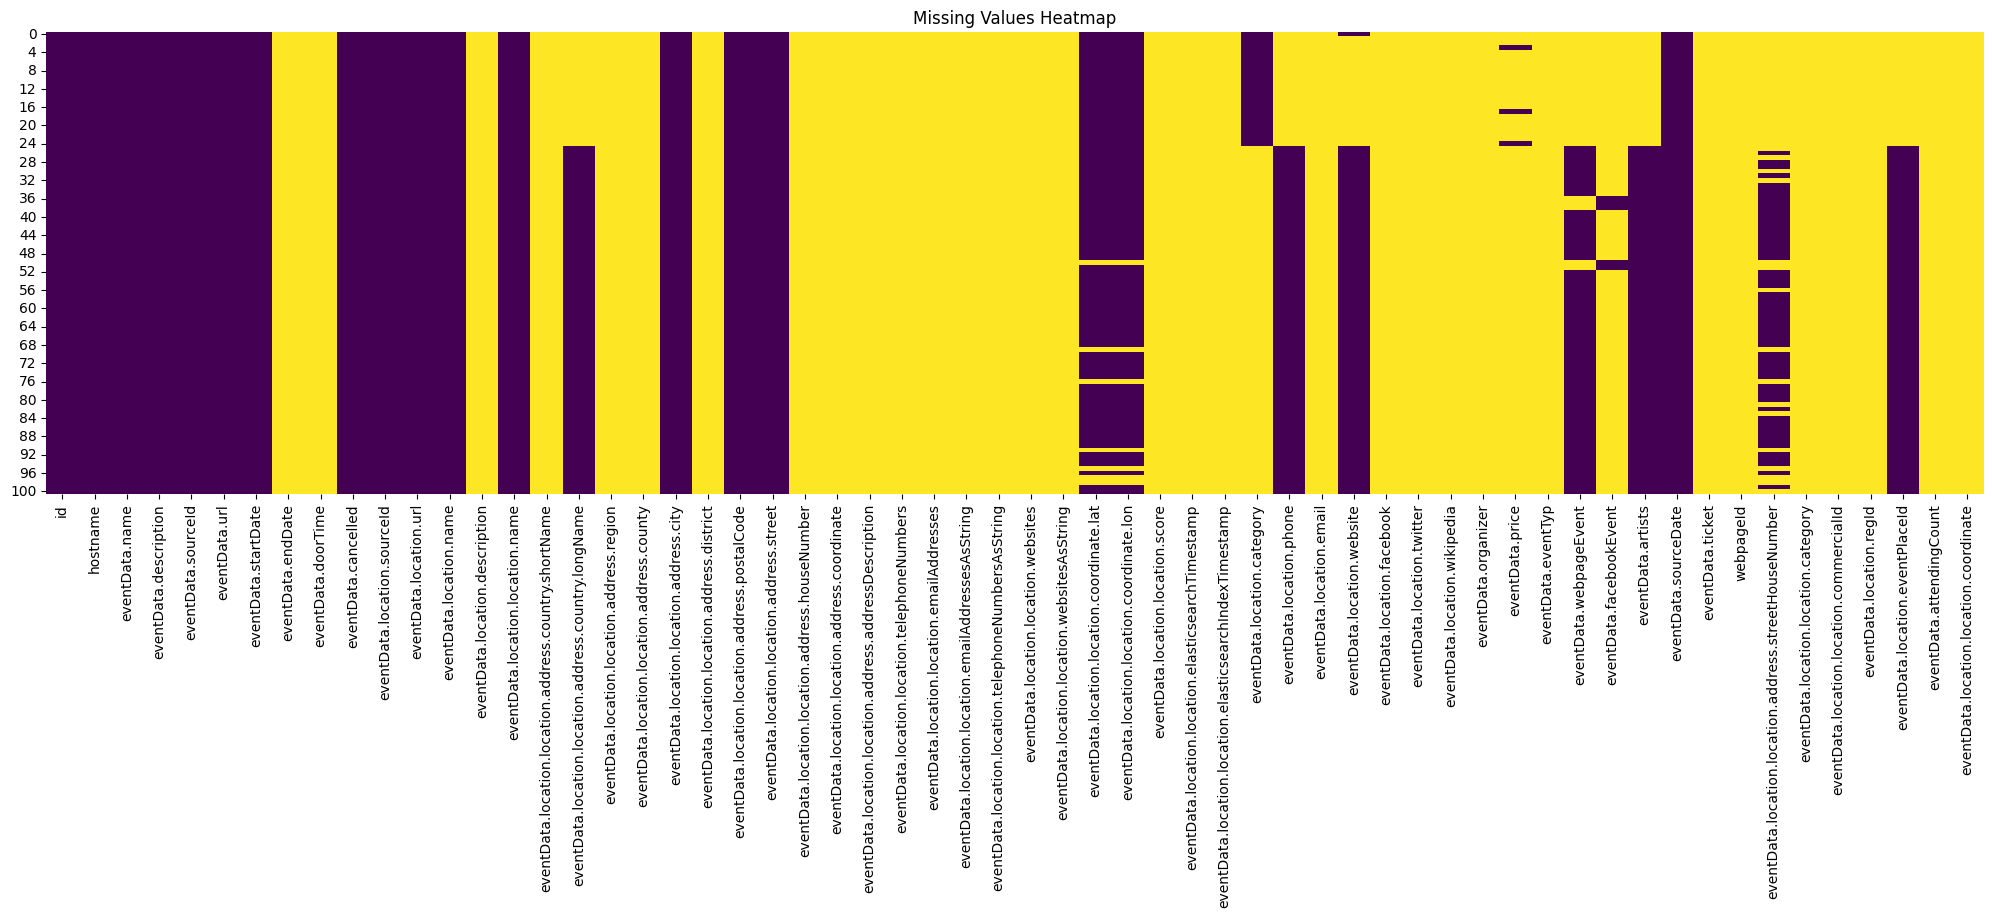

In [8]:
# Create a heatmap of missing values
plt.figure(figsize=(25, 6))  # Adjust the figure size as needed
sns.heatmap(df.isnull(), cmap='viridis', cbar=False)
plt.title('Missing Values Heatmap')
plt.show()

Interpretation: The yellow area shows the NA values. There is a lot of missing data 😨

In [9]:
# delete columns with more than 10% missing values
df = df[df.columns[df.isnull().mean() < 0.1]]
print(df.shape)

(101, 18)


We just deleted a ton of columns because they all contain a lot of missing values and are probably not helpful for further analysis.

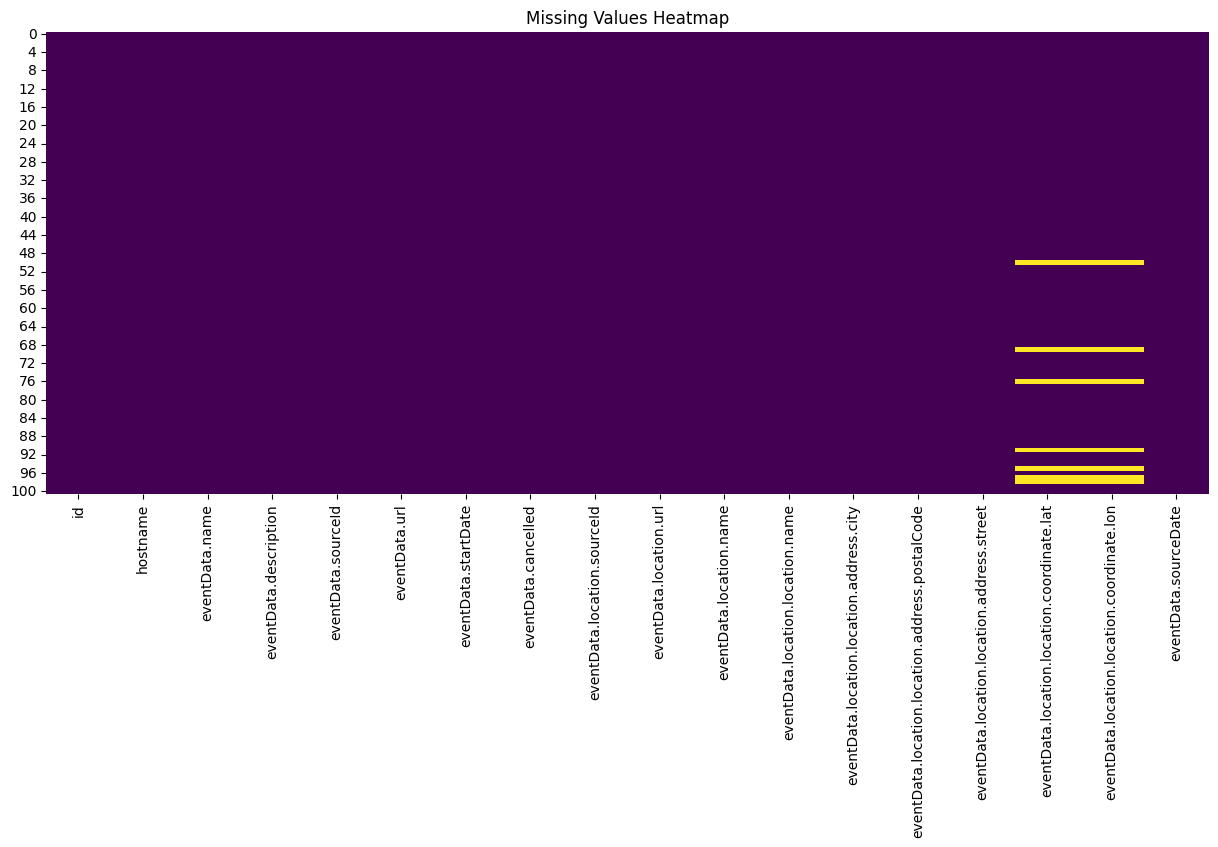

In [10]:
# again plot missing values after cleaning
plt.figure(figsize=(15, 6))  # Adjust the figure size as needed
sns.heatmap(df.isnull(), cmap='viridis', cbar=False)
plt.title('Missing Values Heatmap')
plt.show()

Only latitude and longitude still contain missing values which is quite good. The missing values also always come together.

In [11]:
# check datatypes
print(df.dtypes)

id                                                object
hostname                                          object
eventData.name                                    object
eventData.description                             object
eventData.sourceId                                object
eventData.url                                     object
eventData.startDate                               object
eventData.cancelled                                 bool
eventData.location.sourceId                       object
eventData.location.url                            object
eventData.location.name                           object
eventData.location.location.name                  object
eventData.location.location.address.city          object
eventData.location.location.address.postalCode    object
eventData.location.location.address.street        object
eventData.location.location.coordinate.lat        object
eventData.location.location.coordinate.lon        object
eventData.sourceDate           

In [12]:
print(df.loc[0,])

id                                                                                                                                                                                                                                                                                                                                                                                                                                                                              prinz.de/stuttgart/events/515144-gedenktag-fuer-die-verstorbenen-drogenabhaeng-1
hostname                                                                                                                                                                                                                                                                                                                                                                                                                                                               

### Some simple Feature Engineering

In [13]:
# Convert the date columns to datetime
df['eventData.startDate'] = pd.to_datetime(df['eventData.startDate'], format='%Y-%m-%dT%H:%M:%S')
try:
    df['eventData.sourceDate'] = pd.to_datetime(df['eventData.sourceDate'], format='mixed', errors='coerce')
except:
    print('eventData.sourceDate could not be converted to datetime')


In [14]:
# add a column for the day of the week by using the startDate column
df['eventData.startDate.dayofweek'] = df['eventData.startDate'].dt.dayofweek


In [15]:
print(df['eventData.startDate.dayofweek'].value_counts())

eventData.startDate.dayofweek
5    24
4    22
1    14
3    14
2    11
6     8
0     8
Name: count, dtype: int64


Apparently, 0 means Monday, 1 means Tuesday, 2 means Wednesday and so on...
We only want to have information about events on Wednesdays, so number 2.

In [18]:
# only consider Wednesdays and drop all other days
df = df[df['eventData.startDate.dayofweek'] == 2]
df.reset_index(drop=True, inplace=True)
df.shape

(11, 19)

In [20]:
print(df.head())

                                                                                      id  \
0                              prinz.de/stuttgart/events/203179-3durch3reihe-sprachkunst   
1                                        prinz.de/stuttgart/events/224589-glockenmusik-2   
2      www.last.fm/event/384172+Bernd+Begemann+at+Schaufenster-Mitte+on+21+November+2007   
3  www.last.fm/event/3276697+Touch%C3%A9+Amor%C3%A9+at+Jugendhaus+West+on+22+August+2012   
4            www.last.fm/event/3374473+Charlie+Musselwhite+at+Merlin+on+21+November+2012   

      hostname             eventData.name  \
0     prinz.de  3durch3.reihe Sprachkunst   
1     prinz.de               Glockenmusik   
2  www.last.fm             Bernd Begemann   
3  www.last.fm               Touché Amoré   
4  www.last.fm        Charlie Musselwhite   

                                                                                                                                                                                